In [31]:
import pandas as pd

GAMES = [
    {
        "title": "Watch_Dogs",
        "slug": "watch_dogs",
        "release_date": "2014-07-05", 
        "csv_90d": "watch_dogs_reviews_first90d.csv",
    },
    {
        "title": "Watch_Dogs 2",
        "slug": "watch_dogs_2",
        "release_date": "2021-08-24",
        "csv_90d": "watch_dogs_2_reviews_first90d.csv",
    },
    {
        "title": "Watch Dogs: Legion",
        "slug": "watch_dogs_legion",
        "release_date": "2023-01-26",
        "csv_90d": "watch_dogs_legion_reviews_first90d.csv",
    },
]


Helper function to load the review data from each CSV based on the game title

In [ ]:
def load_reviews_first90(game):
    path = './' + game["csv_90d"]
    print(path)
    df = pd.read_csv(path)
    
    df["game_title"] = game["title"]
    
    df["timestamp"] = pd.to_datetime(df["timestamp_created"], unit="s")
    
    # Date-only
    df["date"] = df["timestamp"].dt.normalize()
    

    release_dt = pd.to_datetime(game["release_date"])
    df["days_since_release"] = (df["date"] - release_dt.normalize()).dt.days + 1
    
    
    df["review_length"] = df["review"].fillna("").str.split().str.len()
    
    df["voted_up"] = df["voted_up"].astype(int)
    
    return df

In [33]:
all_dfs = {}

for game in GAMES:
    df = load_reviews_first90(game)
    all_dfs[game["slug"]] = df
    
    print(f"=== {game['title']} ===")
    print(df[[
        "recommendationid",
        "steamid",
        "timestamp",
        "days_since_release",
        "voted_up",
        "review_length"
    ]].head())

./watch_dogs_reviews_first90d.csv
=== Watch_Dogs ===
   recommendationid            steamid           timestamp  \
0          11092332  76561198067728268 2014-07-05 22:59:28   
1          11093969  76561198090002361 2014-07-06 01:27:43   
2          11094718  76561198106082353 2014-07-06 02:43:56   
3          11096383  76561198016425494 2014-07-06 05:48:05   
4          11096402  76561198107114953 2014-07-06 05:50:07   

   days_since_release  voted_up  review_length  
0                   1         0              9  
1                   2         1            184  
2                   2         1             16  
3                   2         1              4  
4                   2         1             22  
./watch_dogs_2_reviews_first90d.csv
=== Watch_Dogs 2 ===
   recommendationid            steamid           timestamp  \
0          98137385  76561198974152562 2021-08-24 08:27:44   
1          98138341  76561198988403227 2021-08-24 08:55:45   
2          98142206  7656119911116953

In [34]:
def summarize_early_reviews(df: pd.DataFrame, game_title: str) -> pd.Series:
    first30 = df[df["days_since_release"].between(1, 30)].copy()
    
    week1 = first30[first30["days_since_release"].between(1, 7)]
    days8_30 = first30[first30["days_since_release"].between(8, 30)]
    
    summary = pd.Series({
        "game_title": game_title,
        "reviews_1_7": len(week1),
        "reviews_8_30": len(days8_30),
        "reviews_1_30": len(first30),
        "pos_rate_1_30": first30["voted_up"].mean() if len(first30) > 0 else None,
        "pos_rate_1_7": week1["voted_up"].mean() if len(week1) > 0 else None,
        "pos_rate_8_30": days8_30["voted_up"].mean() if len(days8_30) > 0 else None,
        "avg_review_len_1_30": first30["review_length"].mean() if len(first30) > 0 else None,
    })
    
    return summary

In [36]:
summaries = []

for game in GAMES:
    df = all_dfs[game["slug"]]
    s = summarize_early_reviews(df, game["title"])
    summaries.append(s)

summary_df = pd.DataFrame(summaries)
summary_df

,game_title,reviews_1_7,reviews_8_30,reviews_1_30,pos_rate_1_30,pos_rate_1_7,pos_rate_8_30,avg_review_len_1_30
0,Watch_Dogs,159,344,503,0.642147,0.622642,0.651163,87.906561
1,Watch_Dogs 2,87,519,606,0.841584,0.873563,0.836224,12.064356
2,Watch Dogs: Legion,1034,550,1584,0.540404,0.528046,0.563636,49.407828


For each game, I computed early-review features from the first 30 days of my dataset: how many reviews arrive in week 1 vs the rest of the month, how positive they are, and how long they are(text size).
We can see that Watch Dogs: Legion had by far the biggest early spike in review volume but also the lowest positivity, while Watch_Dogs 2 had fewer reviews early on but they were much more positive.

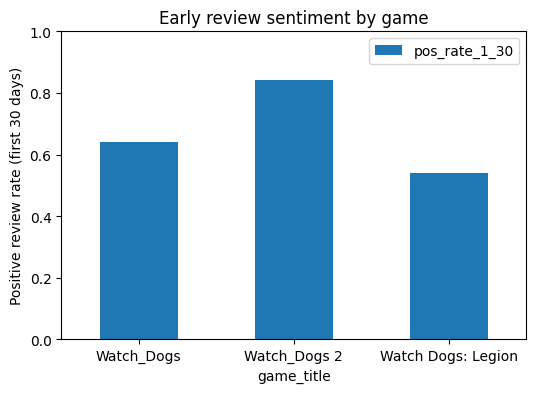

In [41]:
import matplotlib.pyplot as plt
summary_df[["game_title", "pos_rate_1_30"]].set_index("game_title").plot(
    kind="bar", figsize=(6,4)
)
plt.ylabel("Positive review rate (first 30 days)")
plt.title("Early review sentiment by game")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()
